# Initializing and Preprocessing
Load up experiment & annotations

In [3]:
import sys
sys.path.append("//tmp/pycharm_project_688/")
sys.path.append("//tmp/pycharm_project_688/src/")

import pandas as pd
from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction, \
    preprocess_chunks_for_null_test_with_indoor
from preprocessing._segmentation import segment_null_classification, segment_windows
from visualization._visualization import swarm_plot_top_features

%load_ext autoreload
%autoreload 2

from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from visualization import plot_duration_histogram
from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 50
sample_rate = 50
feature_calculation_setting = MinimalFCParameters()

complete_experiments_indices = [1,2,3,5,7]

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Ariane","Julian","Wiktoria"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]

Preprocess data

In [13]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mean 7.44 +/- 11.66
Mean 10.65 +/- 33.83


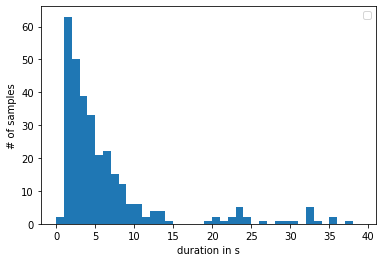

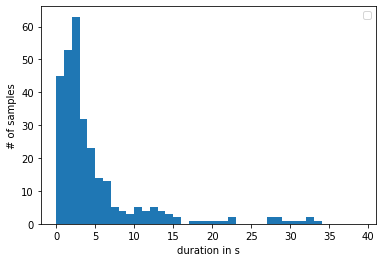

In [14]:
plot_duration_histogram(chunks["right"])
plot_duration_histogram(null_chunks["right"])

# append the action id to the dataframe
# we need to do this to be able to extract time series features later
# Preprocess data


if use_indoor:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test_with_indoor(chunks, null_chunks)
else:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks)

### Segmentation

In [15]:
labels = y.loc[:, "label"].squeeze()


# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


## Binary Classification: OCD activities vs null class samples
### Feature extraction for OCD activities vs non-OCD activities

In [16]:

X_null_class_classification = extract_timeseries_features(null_classification_df, True, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


### Feature selection

In [17]:

impute(X_null_class_classification)
X_null_classification_selected = select_features(X_null_class_classification, labels_null_classification)

In [18]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_null_classification_selected)

In [ ]:
labels_null_classification.values

### Train models and score results

In [19]:
print("Binary classification")
classify_all(X_null_classification, labels_null_classification)

Binary classification
Logistic Regression: 0.68 +/- 0.06
LDA: 0.69 +/- 0.07
LinearSVC: 0.68 +/- 0.07
CART: 0.57 +/- 0.09
Random Forest: 0.59 +/- 0.10
NB: 0.64 +/- 0.07
SVC: 0.64 +/- 0.08


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

In [ ]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

   index         class        features     value
0      0  OCD activity  minor__minimum  0.854411
1      1  OCD activity  minor__minimum  0.854411
2      2  OCD activity  minor__minimum  0.067806
3      3  OCD activity  minor__minimum  0.067806
4      4  OCD activity  minor__minimum  0.854411


KeyboardInterrupt: 

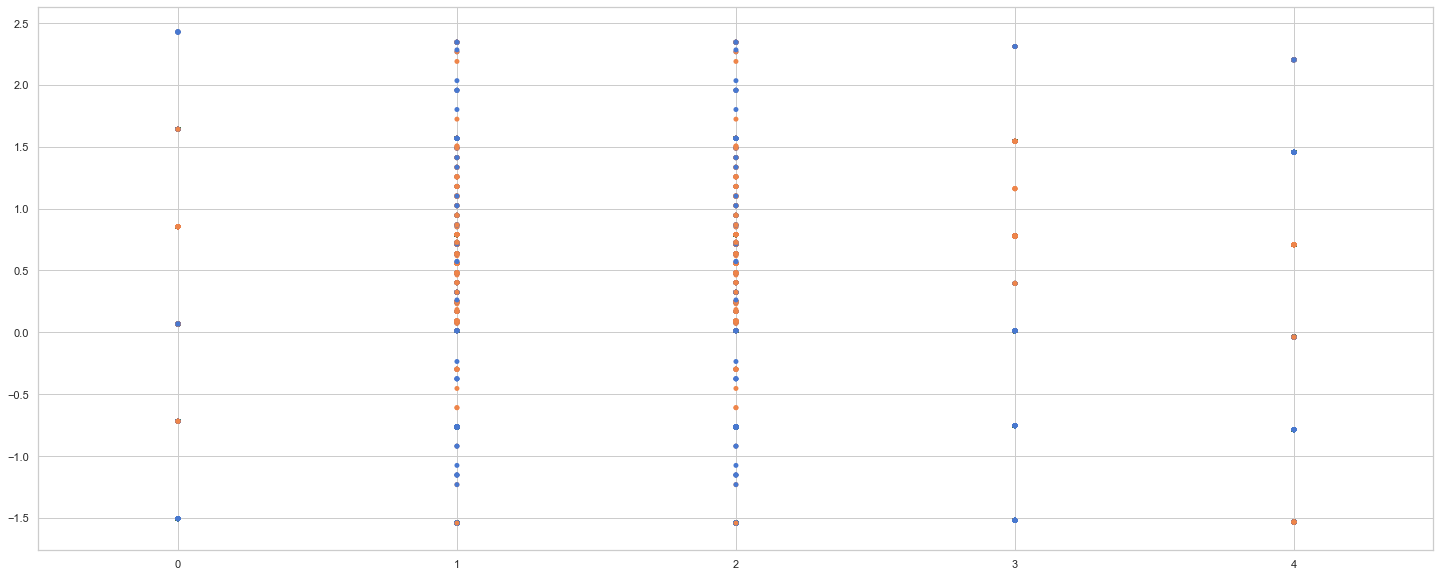

In [20]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_null_classification_selected.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())


# Multiclass classification

For the multi class classification we can reuse
- data loading
- preprocessing
- segmentation

We mainly need to:
- re label the OCD segments with the y array
- do the segmentation for the ocd chunks again
- extract features again
- select and scale features again
- classify again
- visualize results again

In [21]:
# make sure we already run the segmentation for the binary classification earlier

assert len(labels_null_segmented) != 0

labels_ocd_multiclass = labels.reset_index(drop=True)
_, labels_ocd_segmented_multiclass = segment_windows(chunks_ocd, labels_ocd_multiclass.to_numpy(), window_size)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


In [22]:
# reuse chunks_ocd_segmented from the segmentation for the binary classifier
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

In [23]:
labels_multi_class_classification

(0, 0)      pulling  door
(0, 1)      pulling  door
(0, 2)      pulling  door
(0, 3)      pulling  door
(1, 0)       pushing door
                ...      
(617, 1)       null class
(618, 0)       null class
(618, 1)       null class
(619, 0)       null class
(619, 1)       null class
Length: 5348, dtype: object

### Feature extraction for OCD activities vs non-OCD activities

In [34]:
X_multi_class_classification = extract_timeseries_features(mulit_class_df, True, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


In [37]:
X_multi_class_classification.head()
X_multi_class_classification.columns

Index(['acceleration x__length', 'acceleration x__maximum',
       'acceleration x__mean', 'acceleration x__median',
       'acceleration x__minimum', 'acceleration x__standard_deviation',
       'acceleration x__sum_values', 'acceleration x__variance',
       'acceleration x_right__length', 'acceleration x_right__maximum',
       ...
       'minor__sum_values', 'minor__variance', 'rssi__length', 'rssi__maximum',
       'rssi__mean', 'rssi__median', 'rssi__minimum',
       'rssi__standard_deviation', 'rssi__sum_values', 'rssi__variance'],
      dtype='object', name='variable', length=112)

### Feature selection for multi class OCD activities incl null

In [28]:
impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [ ]:
scaler = StandardScaler()
X_multi_class_classification = scaler.fit_transform(X_multi_class_classification_selected)

### Train models and score results

In [30]:
print("Multi class classification with null class")
classify_all(X_multi_class_classification, labels_multi_class_classification)


Multi class classification with null class
Logistic Regression: 0.61 +/- 0.03
LDA: 0.56 +/- 0.05
LinearSVC: 0.60 +/- 0.03
CART: 0.48 +/- 0.05
Random Forest: 0.56 +/- 0.08
NB: 0.26 +/- 0.02
SVC: 0.60 +/- 0.05


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn